## Create toy dataset of a helix with frames tangent to outside surface

### example by  [Tess Smidt](https://blondegeek.github.io/) (GitHub: `blondegeek`)

In this example we will represent coordinate frames as 3 ordered vectors -- this is certainly not the only option.

In [1]:
from functools import partial

import torch
import random

import e3nn
from e3nn.point.data_helpers import DataNeighbors
from e3nn import o3

import matplotlib.pyplot as plt
import numpy as np

torch.set_default_dtype(torch.float64)  # This is the default for e3nn but can be changed if needed

In [2]:
# Create helix
num_revolutions = 2
z_distance = 1 / (2 * np.pi)  # Move up 1 for every 2 * pi
num_points_per_rev = 10  # 10 points per 2 * pi
theta = np.linspace(0, num_revolutions * 2 * np.pi, num_revolutions * num_points_per_rev) 

spiral_coords = np.array([np.sin(theta), np.cos(theta), theta * z_distance]).T
spiral_coords.shape

spiral_frame_out = np.array([
    [ np.cos(theta), -np.sin(theta), np.zeros(len(theta))],
    [ np.sin(theta),  np.cos(theta), np.zeros(len(theta))],
    [np.zeros(len(theta)), np.zeros(len(theta)), np.ones(len(theta))]
])
# points, unit vector (3), xyz (3)
spiral_frame_out = np.einsum('axt->tax', spiral_frame_out)  # Transpose
spiral_frame_in = np.einsum('a,tax->tax', np.array([-1, -1, 1]), spiral_frame_out)

### Create random rotations using random axis and small random angle

In [3]:
from numpy import cross, eye, dot
from scipy.linalg import expm, norm

def M(axis, theta):
    return expm(cross(eye(3), axis/norm(axis)*theta))

def random_small_rotation(sigma=1):
    axis = np.random.randn(3)
    angle = np.pi * sigma * np.random.randn(1)
    return M(axis, angle)

### Use `o3.xyz_to_irrep()` to convert Cartesian frames into 3 irreducible representations (irreps) of L=1

In [4]:
max_radius = 1.5

xyz_to_irrep = o3.xyz_to_irreducible_basis()  # permutation matrix to go from x, y, z to y, z, x
spiral_frame_out_irrep = np.einsum('tax,ix->tai', spiral_frame_out, xyz_to_irrep)
spiral_frame_in_irrep = np.einsum('tax,ix->tai', spiral_frame_in, xyz_to_irrep)
N = spiral_coords.shape[0]

coords = torch.from_numpy(spiral_coords).to(torch.float64)

### Prep train and test  samples

In [5]:
num_train = 500
num_test = 10
num_test_bigsig = 10

xyz_sigma = 0.25
rot_sigma = 0.25

spiral_frame_out = torch.from_numpy(spiral_frame_out).to(torch.float64)

label_frames = torch.einsum('nax,ix->nai', spiral_frame_out, xyz_to_irrep)

trainset = []
for i in range(num_train):
    noise = torch.randn(N, 3) * xyz_sigma
    labels = torch.einsum('nx,ix->ni', -noise, xyz_to_irrep)
    rot_noise = torch.from_numpy(np.stack([random_small_rotation(rot_sigma) for i in range(N)], axis=0)).to(torch.float64)
    inital_frames = torch.einsum('nxy,nay,ix->nai', rot_noise, spiral_frame_out, xyz_to_irrep)
    data = DataNeighbors(x=torch.ones(N, 1), pos=coords + noise, r_max=max_radius, labels=labels,
                         label_frames=label_frames.reshape(N, -1), inital_frames=inital_frames.reshape(N, -1))
    trainset.append(data)

testset = []
for i in range(num_test):
    noise = torch.randn(N, 3) * xyz_sigma
    labels = torch.einsum('nx,ix->ni', -noise, xyz_to_irrep)
    rot_noise = torch.from_numpy(np.stack([random_small_rotation(rot_sigma) for i in range(N)], axis=0)).to(torch.float64)
    inital_frames = torch.einsum('nxy,nay,ix->nai', rot_noise, spiral_frame_out, xyz_to_irrep)
    data = DataNeighbors(x=torch.ones(N, 1), pos=coords + noise, r_max=max_radius, labels=labels,
                         label_frames=label_frames.reshape(N, -1), inital_frames=inital_frames.reshape(N, -1))
    testset.append(data)
    
xyz_sigma = 0.5
testset_big = []
for i in range(num_test):
    noise = torch.randn(N, 3) * xyz_sigma
    labels = torch.einsum('nx,ix->ni', -noise, xyz_to_irrep)
    rot_noise = torch.from_numpy(np.stack([random_small_rotation(rot_sigma) for i in range(N)], axis=0)).to(torch.float64)
    inital_frames = torch.einsum('nxy,nay,ix->nai', rot_noise, spiral_frame_out, xyz_to_irrep)
    data = DataNeighbors(x=torch.ones(N, 1), pos=coords + noise, r_max=max_radius, labels=labels,
                         label_frames=label_frames.reshape(N, -1), inital_frames=inital_frames.reshape(N, -1))
    testset.append(data)
    
torch.save({'max_radius': max_radius,
            'train': trainset, 
            'test': testset, 
            'test_big': testset_big}, 'datasets/data.torch')

### Visualize example
Note, the line connecting dots is just to help visualize -- for network operations a graph is constructed of neighbords within `max_radius`

In [6]:
i = 0
data = trainset[i]
pos = data.pos
init_frame = torch.einsum('nci,ix->ncx', data.inital_frames.reshape(N, 3, 3).cpu().detach(), xyz_to_irrep)
true = torch.einsum('ni,ix->nx', data.labels.cpu().detach(), xyz_to_irrep)
true_frame = torch.einsum('nci,ix->ncx', data.label_frames.reshape(N, 3, 3).cpu().detach(), xyz_to_irrep)

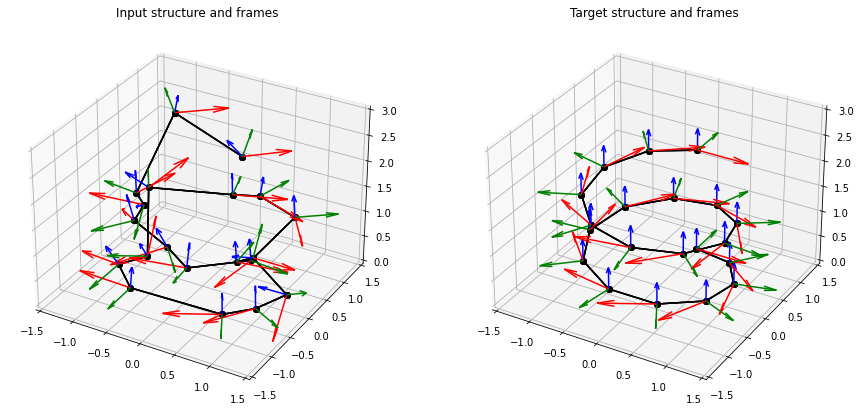

In [7]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(15, 7))
axes = [
    fig.add_subplot(1, 2, i + 1, projection='3d')
    for i in range(2)
]

bound = 1.5

for ax in axes:
    ax.set_xlim(-bound, bound)
    ax.set_ylim(-bound, bound)
    ax.set_zlim(0, 2 * bound)

plot_data = [[pos, init_frame], [pos + true, true_frame]]
colors = ['red', 'green', 'blue']

scale = 0.75

for i, ((xyz, frame), ax) in enumerate(zip(plot_data, axes)):
    for i in range(3):
        ax.plot(xyz[:, 0], xyz[:, 1], xyz[:, 2], marker='o', color='black')
        frame = frame * scale
        ax.quiver(xyz[:, 0], xyz[:, 1], xyz[:, 2], 
                  frame[:, i, 0], frame[:, i, 1], frame[:, i, 2], 
                  length=1, normalize=False, color=colors[i]) 

axes[0].set_title('Input structure and frames')
axes[1].set_title('Target structure and frames')
plt.show()